In [243]:
import cv2
import numpy as np
import urllib.request
import validators
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

from pytriton.client import ModelClient

import os
from pathlib import Path
import random

### Helper functions

In [244]:
def show_image(image_array):
    image = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)


    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [245]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

### Generate SAM masks via pytriton server

SAM mask generator returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `stability_score` : an additional measure of mask quality

In [246]:
# Returns a list of dictionaries containing the info of each mask
def infer_model(url='http://202.92.132.48:8000', image='images/wonder_cat.jpg', model='SAM_h', init_timeout_s=600.0):
    with ModelClient(url, model, init_timeout_s=init_timeout_s) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        outputs = client.infer_sample(image=image)
        segmentation = outputs['segmentation']
        #area = masks['area']
        masks = []
        for i in range(segmentation.shape[0]):
            masks.append({
                'segmentation': segmentation[i,:,:],
                'area': outputs['area'][i],
                'bbox': outputs['bbox'][i],
                'predicted_iou': outputs['predicted_iou'][i],
                'stability_score': outputs['stability_score'][i],
            })


        '''
        FORMAT:

        masks = [{
            'segmentation': ndarray,
            'area': numpy.float32,
            'bbox': ndarray,
            'predicted_iou': numpy.float,
            'stability_score': numpy.float
            
            
            ...more (k,v) pairs in next functions
        }]
        '''

        
        return image, masks

### Image selection

In [247]:
image_path = input("Enter image path, URL, 'r' for random, empty for default: ")

input_key = 0

if image_path == "":
    input_key = 0
    image_path = "images/aki_dog.jpg"

elif image_path == 'r':
    input_key = 2

else: # User uploaded image
    input_key = 1


This project assumes that the COCO 2017 validation split images and the corresponding annotatinons files have been saved locally.

Inside the dataset folder, add another folder named `annotations` which has the `instances_val2017.json` file.

Set `coco_path` to point to the folder with the dataset images.

In [248]:
coco_path = '../val2017'
annotation_path = coco_path + '/annotations/instances_val2017.json'

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


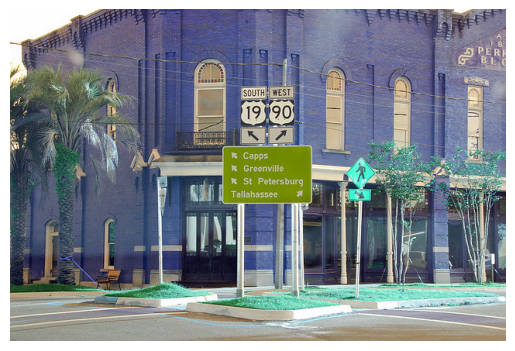

bench
	segmentation
		[[113.14, 353.84, 111.31, 350.58, 111.83, 345.76, 120.44, 344.72, 124.61, 343.93, 126.82, 337.42, 143.51, 336.24, 139.34, 347.84, 143.77, 362.84, 141.55, 362.18, 138.95, 354.1, 129.95, 354.49, 129.56, 362.84, 126.04, 362.71, 125.26, 358.53, 123.3, 354.36, 117.31, 354.1, 115.09, 354.49, 114.05, 356.06], [112.09, 356.58, 111.83, 361.14, 113.79, 361.14, 113.92, 357.62]]
	area
		462.6850499999998
	iscrowd
		0
	image_id
		509258
	bbox
		[111.31, 336.24, 32.46, 26.6]
	category_id
		15
	id
		1392913


In [249]:
# Init COCO object
coco = COCO(annotation_path)



# Get all category IDs
category_ids = coco.getCatIds()

# Load category info for each category_id
categories = coco.loadCats(category_ids)

# Extract the names of the categories into a list
category_names = {}
for category in categories:
    category_names.update({category['id'] : category['name']})
# print(category_names)


# Get random image from COCO
image_ids = coco.getImgIds()

random_image_id = random.choice(image_ids)

image_info = coco.loadImgs(random_image_id)[0]

random_image_path = coco_path + '/' + image_info['file_name']

random_image = plt.imread(random_image_path)

annotation_ids = coco.getAnnIds(imgIds=random_image_id)
annotations = coco.loadAnns(annotation_ids)

if input_key == 2:
    image_path = random_image_path


show_image(random_image)

for a in annotations:
    idx = a['category_id']
    print(category_names[idx])
    pretty(a, 1)

### Perform Segmentation

In [250]:
image, masks = infer_model(image=image_path)

Crop masks

In [251]:
def process_masks(image, masks):
    # Crop and save each segmented mask in /cropped folder

    # Clear cropped folder before saving new crops
    for filename in os.listdir('cropped/'):
        file_path = os.path.join('cropped/', filename)
    
        # Check if the path is a file (not a subdirectory)
        if os.path.isfile(file_path):
            # Delete the file
            os.remove(file_path)
    
    i=0
    for mask in masks:
        # print(mask['bbox'])
        x, y, w, h = mask['bbox']
        # print(x, y, w, h)

        cropped_img = image[y:y+h, x:x+w].copy()
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        
        filename = '%i.jpg'%i

        # Add to mask dict
        mask.update({'filename': filename})
        mask.update({'cropped_img': cropped_img})
        mask.update({'mask_id': i})

        # Save image
        path = Path('cropped/')
        filepath = os.path.join(path, filename)
        # print(filepath)
        cv2.imwrite(filepath, cropped_img)
        # print(mask)
        i+=1
    # print(i)
    # return mask_crops

Crop images and add relevant info to the masks list (of dictionaries) generated by SAM

In [252]:
process_masks(image, masks)

# Model pytriton calls

### OpenCLIP pytriton call

In [253]:
def openclip_model(url='http://202.92.132.48:8000', image='images/wonder_cat.jpg', openclip_model='OpenClip_b32', coca_model='CoCa_l14', init_timeout_s=600.0):
    with ModelClient(url, openclip_model, init_timeout_s=init_timeout_s) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = np.expand_dims(image, axis=0)
        # logger.info(f"Running inference requests")
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "index":
                # print(k, v, v.shape)
                continue
            else:
                # print(v)
                label = v.tobytes().decode('utf-32')
                # print(label)
                # print(label)
                return label

### CoCA pytriton call

In [254]:
def coca_model(url='http://202.92.132.48:8000', image='images/wonder_cat.jpg', coca_model='CoCa_l14', init_timeout_s=600.0):
    with ModelClient(url, coca_model, init_timeout_s=init_timeout_s) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # logger.info(f"Running inference requests")
        outputs = client.infer_sample(image)
        # print(outputs)
        for k, v in outputs.items():
            coca_prediction = v.tobytes().decode('utf-32')
            # print(coca_prediction)
            return(coca_prediction)

### YOLOv8 pytriton call

This example shows how to run [Yolov8](https://docs.ultralytics.com/) by Ultralytics on a remote PyTriton server. Similar to the previous examples, the image will be loaded from client side and transmitted to the server over http for inference. The server returns the following:

* `bboxes` - an array of bounding boxes. Each item refers to detected object in MSCOCO 80 classes.
* `probs` - an array of probabilities for each detected object.
* `names` - a `|` - separated of names of detected objects.

In [255]:
def yolo_model(url="http://202.92.132.48:8000", image="../sam/images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
                outputs['names'] = names
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        
        return outputs   

# Per-mask CoCa Prediction

Query each mask and append CoCa prediction into the `masks` dictionary

In [256]:
mask_files = os.listdir('cropped/')

# mask_predictions = []
for file in mask_files:
    for mask in masks:
        # print( file.strip('.jpg'), mask['mask_id'])
        
        if str(mask['mask_id']) == file.strip('.jpg'):
            # mask_predictions.append(openclip_model(image='cropped/'+file))
            # print('COCA PRED', coca_model(image='cropped/'+file))
            mask.update({'coca_pred': coca_model(image='cropped/'+file)})
            break
            

In [275]:
for mask in masks:
    print(mask['filename'], mask['coca_pred'])


0.jpg a close - up view of a road with grass in the background . 
1.jpg a street sign that is on the side of a road . 
2.jpg a black and white photo of a window . 
3.jpg a close - up view of a sign on the side of a building . 
4.jpg a close up of a pen with a pen holder on it 
5.jpg a close - up picture of a green background . 
6.jpg a close - up of a street sign that reads " scout - tech ". 
7.jpg a brick building with a fence on the side of it 
8.jpg a close - up picture of a green field . 
9.jpg [{'name': 'person', 'category_id': 1, 'iou': 0.0}, {'name': 'car', 'category_id': 3, 'iou': 0.0}]
10.jpg an arrow pointing to the right on a computer screen . 
11.jpg an image of a green background with an arrow . 
12.jpg [{'name': 'person', 'category_id': 1, 'iou': 0.0}]
13.jpg a blurry image of a white background 
14.jpg a close - up image of a street sign . 
15.jpg a close - up picture of a grassy area . 
16.jpg a tall white cabinet on the side of a brick wall . 
17.jpg a view of a buildi

In [276]:
# # OPEN CLIP
# for file in mask_files:
#     for mask in masks:
#         # print( file.strip('.jpg'), mask['mask_id'])
        
#         if str(mask['mask_id']) == file.strip('.jpg'):
#             mask.update({'oclip_pred': openclip_model(image='cropped/'+file)})

In [278]:
# for mask in masks:
#     print(mask['filename'], mask['oclip_pred'])

0.jpg wing
1.jpg street sign
2.jpg flute, transverse flute
3.jpg street sign
4.jpg flute, transverse flute
5.jpg guacamole
6.jpg street sign
7.jpg tile roof
8.jpg broccoli
9.jpg space bar
10.jpg scabbard
11.jpg iron, smoothing iron
12.jpg seashore, coast, seacoast, sea-coast
13.jpg space bar
14.jpg street sign
15.jpg space bar
16.jpg window screen
17.jpg picket fence, paling
18.jpg space bar
19.jpg space bar
20.jpg space bar
21.jpg street sign
22.jpg scabbard
23.jpg church, church building
24.jpg space bar
25.jpg hen
26.jpg ox
27.jpg scoreboard
28.jpg turnstile
29.jpg flute, transverse flute
30.jpg refrigerator, icebox
31.jpg spindle
32.jpg street sign
33.jpg seashore, coast, seacoast, sea-coast
34.jpg scabbard
35.jpg bow tie, bow-tie, bowtie
36.jpg lemon
37.jpg space bar
38.jpg liner, ocean liner
39.jpg space bar
40.jpg window screen
41.jpg flagpole, flagstaff
42.jpg scabbard
43.jpg space bar
44.jpg zucchini, courgette
45.jpg flute, transverse flute
46.jpg space bar
47.jpg window scre

In [260]:
def find_COCO_object(categories, coca_pred):
    categories_present = []
    for category in categories:
        # print(category, coca_pred)
        if category['name'] in coca_pred:
            categories_present.append({
                'name': category['name'],
                'category_id': category['id']
            })
    print(categories_present)
    return categories_present
        
        

Check if label is in COCO, append masks with CoCa predictions that are present in COCO into masks_copy

In [261]:
for mask in masks:
    found = find_COCO_object(categories, mask['coca_pred'])

    if not bool(found):
        mask.update({'in_coco': False})
    else:
        mask.update({'in_coco': True})
        mask['coca_pred'] = found

masks_copy = []
for mask in masks:

    if mask['in_coco']:
        masks_copy.append(mask)

print(len(masks))
print(len(masks_copy))

# for mask in masks_copy:
#     print(mask['mask_id'], mask['coca_pred'], mask['in_coco'])

[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'name': 'person', 'category_id': 1}, {'name': 'car', 'category_id': 3}]
[]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]
[]
[]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]
[]
[]
[]
[{'name': 'book', 'category_id': 84}]
[]
[]
[]
[]
[]
[]
[]
[{'name': 'person', 'category_id': 1}]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]
[]
[{'name': 'person', 'category_id': 1}]
[{'name': 'cat', 'category_id': 17}]
[]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]
[{'name': 'boat', 'category_id': 9}]
[{'name': 'person', 'category_id': 1}]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'name': 'book', 'category_id': 84}]
[]
[]
[]
[{'name': 'car', 'category_id': 3}]
[{'name': 'person', 'category_id': 1}]
[{'name': 'car', 'category_id': 3}]
[]
[]
[]
[]
[{'name': 'book', 'category_id': 84}]
[]
[{'name': 'person', 'category_id': 1}]
[]
[]
[]
[]
[{'name': 'chair', 'category_id': 62}]
[]
[]
[]
[{'name': 'person', 'category_id': 1}]
[{'name': 'car', 'category_id': 3}]
[]
[]
[]
[]


# YOLOv8 Prediction

Put objects detected in the overall image by YOLOv8 in the list `yolo_predictions`.

In [262]:
# YOLO output serves as ground truth for user-uploaded images i.e images that do not come from the COCO 2017 val split.
yolo_output = yolo_model(image=image_path)

# Reformat yolo_output dictionary to a list of dictionaries with each item being a YOLOv8-detected object
# For easier, iteration with masks list
yolo_predictions = []
for i in range(len(yolo_output['names'])):
    object_dict = {
        'name': yolo_output['names'][i],
        'bboxes': yolo_output['bboxes'][i],
        'probs': yolo_output['probs'][i]
    }
    yolo_predictions.append(object_dict)

# YOLO bbox in format [x1 y1 x2 y2]
# Convert YOLO to [x y w h]
for p in yolo_predictions:
    for k, v in p.items():
        if k == 'bboxes':
            x1, y1, x2, y2 = v
            v[0] = x1 
            v[1] = y1
            v[2] = x2 - x1
            v[3] = y2 - y1
        print(k, v)
    

name bench
bboxes [110.54593  335.67682   33.988922  27.715332]
probs 0.83301204


# Compute IOU of GT

Compute_iou function

In [263]:
def compute_iou(bbox1, bbox2):
    print('Computing iou...')

    x1 = bbox1[0]
    y1 = bbox1[1]
    w1 = bbox1[2]
    h1 = bbox1[3]

    x2 = bbox2[0]
    y2 = bbox2[1]
    w2 = bbox2[2]
    h2 = bbox2[3]

    intersection_width = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    intersection_height = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    intersection_area = intersection_width * intersection_height

    area_box1 = w1 * h1
    area_box2 = w2 * h2

    union_area = area_box1 + area_box2 - intersection_area

    iou = intersection_area / union_area

    print ('sam_box:', bbox1)
    print ('gt_box:', bbox2)

    return iou

In [264]:
def sam_yolo(masks_copy, yolo_predictions):

    # For each mask, compute the IOU between YOLO prediction and CoCa prediction

    for mask in masks_copy:
        
        for prediction in yolo_predictions:
            if prediction['probs'] < 0.5: continue # Skip low-prob YOLO predicts

            coca_predictions = mask['coca_pred']

            for p in coca_predictions:

                print(type(coca_predictions), coca_predictions)
                print(p)
                print(prediction)
                
                sam_bbox = mask['bbox']
                yolo_bbox = prediction['bboxes']
                
                if yolo_bbox.size == 0: continue

                # Check if yolo_prediction is the same as coca_prediction
                print(prediction['name'], p['name'])

                if prediction['name'] == p['name']:
                    iou = compute_iou(sam_bbox, yolo_bbox)
                    
                    if p['iou'] < iou:
                        p['iou'] = iou

                    if iou >= 0.7:
                        show_image(mask['cropped_img'])

                    print(mask['mask_id'], '\t',mask['coca_pred'], prediction['name'], p['iou'])


In [265]:
def sam_coco(masks_copy, coco_gt):
    for mask in masks_copy:
        
        for detection in coco_gt:
            
            coca_predictions = mask['coca_pred']

            for p in coca_predictions:
                
                sam_bbox = mask['bbox']
                coco_gt_bbox = detection['bbox']

                if detection['category_id'] == p['category_id']:
                    iou = compute_iou(sam_bbox, coco_gt_bbox)

                    if p['iou'] < iou:
                        p['iou'] = iou

                    if iou >= 0.7:
                        show_image(mask['cropped_img'])

                    print(mask['mask_id'], '\t',mask['coca_pred'], category_names.get(detection['category_id']), p['iou'])

Compute iou for each mask

In [266]:
# Populate masks with iou = 0
for mask in masks_copy:
    coca_predictions = mask['coca_pred']

    for p in coca_predictions:
        p.update({'iou': 0.0})

    
# If input is user-uploaded or a default image
if input_key == 0 or input_key == 1:
    sam_yolo(masks_copy=masks_copy, yolo_predictions=yolo_predictions)

# If input is 'r' (random)
if input_key == 2:
    sam_coco(masks_copy=masks_copy, coco_gt=annotations)


    

For each mask, find coca_prediction with highest IOU

In [267]:
# For each mask, find coca_prediction with highest IOU

highest_iou = None
for mask in masks_copy:
    
    prediction = mask['coca_pred']
    temp = 0.0
    print(prediction)
    for a in prediction:
        print(a)
        if a['iou'] > temp:
            temp = a['iou']
    
    for a in prediction:
        if a['iou'] == temp:
            highest_iou = a

    mask.update({
        'name': highest_iou['name'],
        'category_id': highest_iou['category_id'],
        'iou': highest_iou['iou']
    })
    

for mask in masks_copy:
    print(mask['mask_id'], mask['category_id'], mask['name'], mask['bbox'], mask['iou'])


[{'name': 'person', 'category_id': 1, 'iou': 0.0}, {'name': 'car', 'category_id': 3, 'iou': 0.0}]
{'name': 'person', 'category_id': 1, 'iou': 0.0}
{'name': 'car', 'category_id': 3, 'iou': 0.0}
[{'name': 'person', 'category_id': 1, 'iou': 0.0}]
{'name': 'person', 'category_id': 1, 'iou': 0.0}
[{'name': 'person', 'category_id': 1, 'iou': 0.0}]
{'name': 'person', 'category_id': 1, 'iou': 0.0}
[{'name': 'book', 'category_id': 84, 'iou': 0.0}]
{'name': 'book', 'category_id': 84, 'iou': 0.0}
[{'name': 'person', 'category_id': 1, 'iou': 0.0}]
{'name': 'person', 'category_id': 1, 'iou': 0.0}
[{'name': 'person', 'category_id': 1, 'iou': 0.0}]
{'name': 'person', 'category_id': 1, 'iou': 0.0}
[{'name': 'person', 'category_id': 1, 'iou': 0.0}]
{'name': 'person', 'category_id': 1, 'iou': 0.0}
[{'name': 'cat', 'category_id': 17, 'iou': 0.0}]
{'name': 'cat', 'category_id': 17, 'iou': 0.0}
[{'name': 'person', 'category_id': 1, 'iou': 0.0}]
{'name': 'person', 'category_id': 1, 'iou': 0.0}
[{'name': 'bo

In [268]:
def draw_figure(image, masks):
    # Plotting
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')

    for mask in masks:
        if mask['iou'] > 0.7:
            x, y, w, h = mask['bbox']
            color = np.random.rand(3,)
            rect = plt.Rectangle((x, y), w, h, fill=False, color=color)
            ax.add_patch(rect)
            color = np.append(color, 0.5)
            ax.text(x, y, f"{mask['name']} iou:{mask['iou']:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

# My Prediction

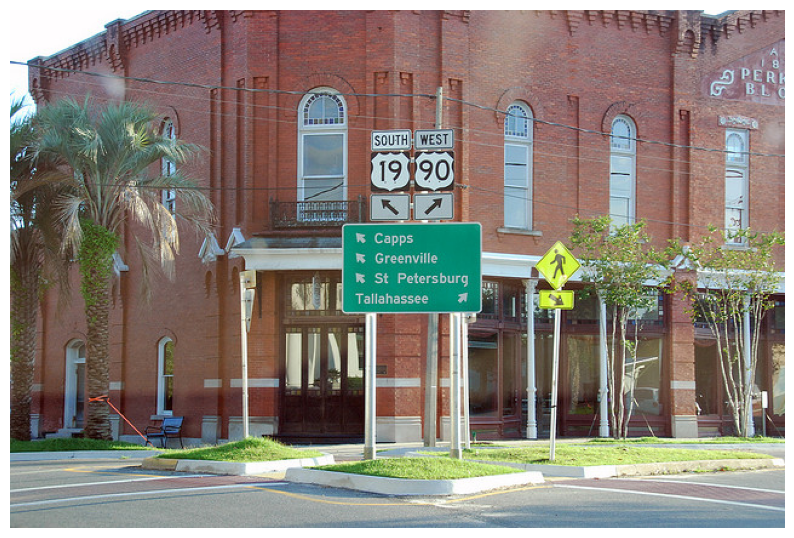

In [269]:
draw_figure(image, masks_copy)

# YOLO Prediction

In [270]:
def draw_yolo(url="http://202.92.132.48:8000", image="../sam/images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
                outputs['names'] = names
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v

        
        
        # Plotting
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)
        ax.axis('off')
        for i in range(len(names)):
            if probs[i] > 0.5:
                x1, y1, x2, y2 = bboxes[i]
                w = x2 - x1
                h = y2 - y1
                # make the color random
                color = np.random.rand(3,)
                rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
                ax.add_patch(rect)
                # use the color and add transparency of 0.5
                color = np.append(color, 0.5)
                # add text with white background
                ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
        


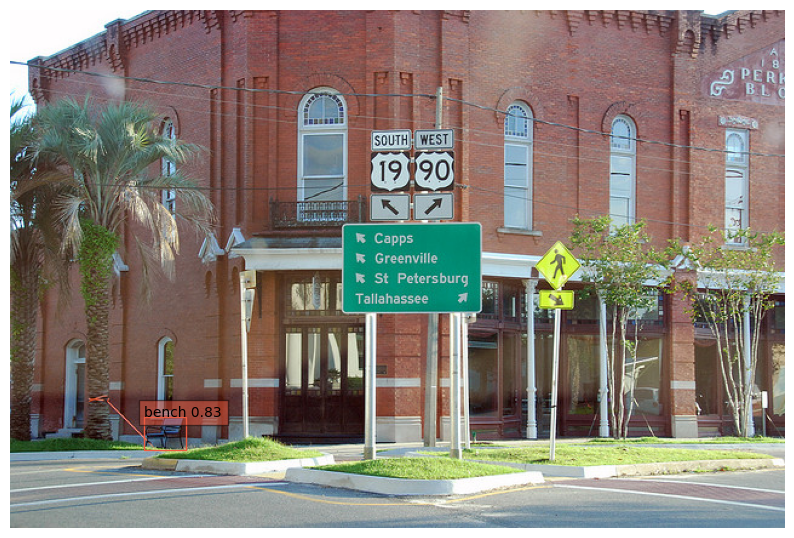

In [271]:
draw_yolo(image=image_path)

# COCO Ground Truth

In [272]:
def draw_coco(image_path=image_path, annotations=annotations):
    # image = plt.imread(image_path)
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')
    
    for a in annotations:
        x, y, w, h = a['bbox']
        color = np.random.rand(3,)
        rect = plt.Rectangle((x, y), w, h, fill=False, color=color)
        ax.add_patch(rect)
        # use the color and add transparency of 0.5
        color = np.append(color, 0.5)
        # add text with white background
        ax.text(x, y, f"{category_names[a['category_id']]}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

    

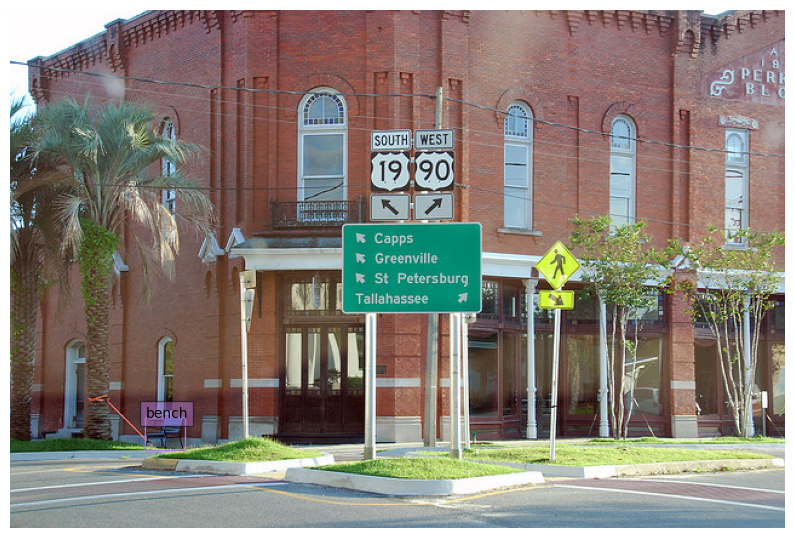

In [273]:
if input_key == 2:
    draw_coco()